In [2]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [14]:
import importlib
from sentence_transformers import SentenceTransformer
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from src import elastic_search_engine, rag

In [4]:
importlib.reload(elastic_search_engine)
importlib.reload(rag)

<module 'src.rag' from '/home/taras/my_code_for_courses/llm-zoomcamp/Project/src/rag.py'>

In [5]:
import pandas as pd
import json

In [6]:
with open('../data/initial_data_w_id.json', 'r') as f_in:
    documents = json.load(f_in)

In [7]:
doc_idx = {d['id']: d for d in documents}

# Example of a possible RAG

In [8]:
elastic_semantic_searcher = elastic_search_engine.ElasticSemanticSearcher(index_name='vague-actual-mpnet')
prompt_template = """
    Your are a translator from vague boss language into an everyday language. Translate
    the VAGUE statement or question based on the CONTEXT. Provide a clear and concise translation. Provide only the translation and no other information.
    VAGUE: {vague}
    
    CONTEXT: {context}
    """.strip()
    
chatgpt_4o_mini = rag.ChatGPTRAG(elastic_searcher=elastic_semantic_searcher,
                 prompt_template=prompt_template, 
                 llm_model='gpt-4o-mini',
                 sentence_transformer_name='all-mpnet-base-v2')

/home/taras/.local/share/virtualenvs/llm-zoomcamp-sfbU5DAF/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [9]:
chatgpt_4o_mini.rag_results('We need to become Speedy Gonzales and kick it into hyperdrive or we are going to be stuck in traffic.')

'We need to speed up our work to avoid delays.'

## Evaluation for different RAGs

In [10]:
ground_truth = pd.read_csv('../data/ground_truth_data.csv')

I will randomly take 800 documents for RAG evaluation to save time and money.

In [11]:
ground_truth = ground_truth.sample(800)

In [12]:
ground_truth = ground_truth.to_dict(orient='records')

In [13]:
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor

pool = ThreadPoolExecutor(max_workers=6)

def map_progress(pool, seq, f, model):
    results = []
    with tqdm(total=len(seq)) as progress:
        futures = []
        for el in seq:
            future = pool.submit(f, el, model)
            future.add_done_callback(lambda p: progress.update())
            futures.append(future)
        for future in futures:
            result = future.result()
            results.append(result)
    return results

In [14]:
def process_record(rec, model):
    answer_llm = model.rag_results(rec['vague'])
    
    doc_id = rec['doc_id']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['actual']

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'vague': rec['vague'],
    }

In [15]:
process_record(ground_truth[5], chatgpt_4o_mini)

{'answer_llm': 'We need to organize our strategies to align with the overall company goals.',
 'answer_orig': 'We need to organize our resources as we work to improve our IT infrastructure.',
 'document': '71431fe22ddd3f00f79bea0c094d92e5',
 'vague': 'We should get our ducks in order as we navigate towards a stronger infrastructure.'}

In [ ]:
result_prompt_standard = map_progress(pool, ground_truth, process_record, chatgpt_4o_mini)

In [ ]:
pd.DataFrame(result_prompt_standard).to_csv(r'../data/standard_prompt_rag_evaluation.csv', index=False)

## Ambiguity resolver RAG

In [16]:
ambiguity_resolver_prompt = """You are an Ambiguity Resolver for tech management communication. Your task is to:

1. Interpret the VAGUE STATEMENT from an IT manager
2. Consider the given CONTEXT
3. Rewrite the statement in clear, specific, and actionable terms

Provide only the rewritten statement without additional commentary.

VAGUE STATEMENT: {vague}

CONTEXT: {context}

CLEAR STATEMENT:""".strip()

In [17]:
ambiguity_resolver_rag= rag.ChatGPTRAG(elastic_searcher=elastic_semantic_searcher,
                 prompt_template=ambiguity_resolver_prompt, 
                 llm_model='gpt-4o-mini',
                 sentence_transformer_name='all-mpnet-base-v2')

/home/taras/.local/share/virtualenvs/llm-zoomcamp-sfbU5DAF/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [18]:
ambiguity_resolver_rag.rag_results('We need to become Speedy Gonzales and kick it into hyperdrive or we are going to be stuck in traffic.')

'We need to accelerate our development process to ensure we meet project deadlines.'

In [20]:
result_ambiguity_resolver = map_progress(pool, ground_truth, process_record, ambiguity_resolver_rag)

  0%|          | 0/800 [00:00<?, ?it/s]

In [21]:
pd.DataFrame(result_ambiguity_resolver).to_csv('../data/ambiguity_resolver_rag_evaluation.csv', index=False)

### Comparing

In [8]:
def compute_similarity(record, sentence_transformer_model):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = sentence_transformer_model.encode(answer_llm)
    v_orig = sentence_transformer_model.encode(answer_orig)
    
    return v_llm.dot(v_orig)


In [6]:
standard_rag_evaluation = pd.read_csv(r'../data/standard_prompt_rag_evaluation.csv')
ambiguity_resolver_rag_evalution = pd.read_csv('../data/ambiguity_resolver_rag_evaluation.csv')
sentence_model_transformer = SentenceTransformer('all-mpnet-base-v2')

/home/taras/.local/share/virtualenvs/llm-zoomcamp-sfbU5DAF/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [9]:
standard_rag_results = [compute_similarity(rec, sentence_transformer_model=sentence_model_transformer)
                        for rec in standard_rag_evaluation.to_dict(orient='records')]

In [10]:
ambiguity_resolver_rag_results = [compute_similarity(rec, sentence_transformer_model=sentence_model_transformer)
                        for rec in ambiguity_resolver_rag_evalution.to_dict(orient='records')]

In [13]:
pd.DataFrame({'sim': standard_rag_results}).to_csv('../data/standard_rag_results.csv', index=False)
pd.DataFrame({'sim': ambiguity_resolver_rag_results}).to_csv('../data/ambiguity_resolver_rag_results.csv', index=False)

/tmp/ipykernel_25820/30980072.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(standard_rag_results, label='standard')
/tmp/ipykernel_25820/30980072.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ambiguity_resolver_rag_results, label='ambiguity_resolver')


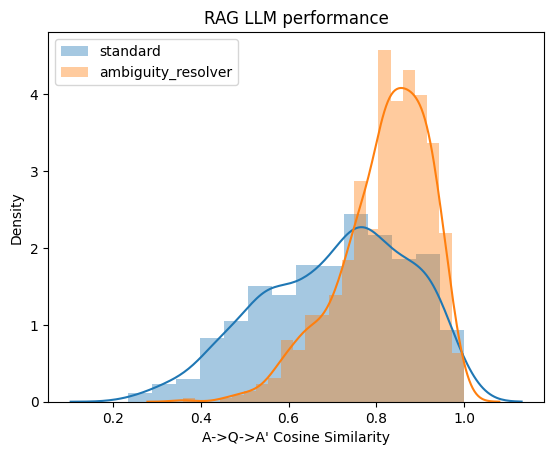

In [17]:

sns.distplot(standard_rag_results, label='standard')
sns.distplot(ambiguity_resolver_rag_results, label='ambiguity_resolver')

plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()


## LLM-as-a-judge

## Summary
In what follows I wil use ambiguity_resolver rag.